In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch
import random

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

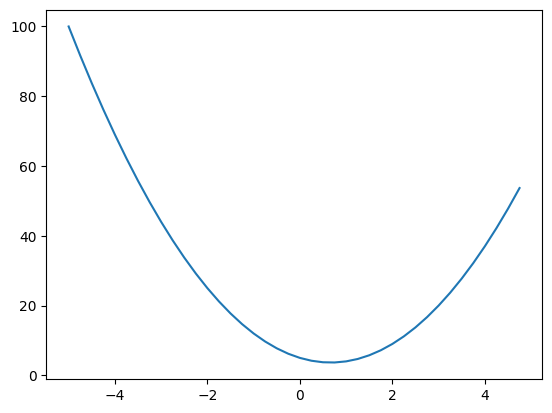

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)
#parabola

In [5]:
#derivative explanation - telling us how to measure the slope of the function
# we need to take a really small h to measure it 
h = 0.00000001
x = 2/3
(f(x+h)- f(x))/h #from definition of the derevative 

0.0

In [6]:
# more complex example
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10
d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [96]:
# building the structure to hold the values
class Value:
    def __init__(self, data, _children = (), _op= '', label = ''):
        self.data = data
        self.grad = 0.0 # at initial it does not affect the output
        #grad represents the derevative of the output with the
        #respect to given value like a,b,c
        
        #backpropagation
        self._backward = lambda: None
        self._prev = set(_children) #set of children
        self._op = _op # the operation that was used between children
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self+other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # added += to make sure we can re-use the variable
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int float power"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad+=other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # implementing topological sort - to make sure that backpropagation
        # happens in a proper order 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [97]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
a-b
#python calls a.__add__(b) so a is self and b is other

Value(data=5.0)

In [10]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c') 
a*b + c
#(a.__mul__(b)).__add__(c)

Value(data=4.0)

In [14]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c') 
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'l'

In [15]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

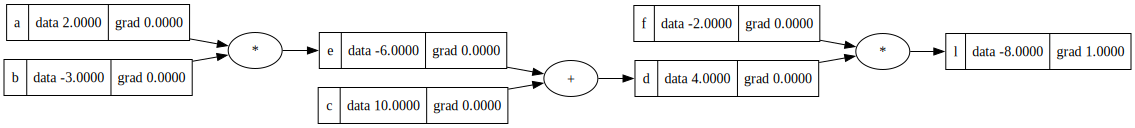

In [21]:
draw_dot(L)

L = d*f
dL/dd ?
Proof from derivatives:
(f(x+h) - f(x)) / h =>

((d+f)*f - d*f)/h =>
(d*f + h*f - d*f) / h =>
(h*f)/h =>
f

dd / dc ?

d = c+e

(f(x+h) - f(x)) / h =>

((c+h + e) - (c+e))/h
(c + h + e - c - e) / h
h/h = 1.0

WANT:
dL/dc

KNOW:
dL / dd
dd / dc

CHAIN RULE: 
dL/dc = (dL / dd) * (dd / dc)

In [20]:
L.grad = 1.0 # as you can see in the lol function below changeing the
#l by the h equals to 1. 

In [19]:
def lol():
    h = 0.0001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c') 
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'l'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c') 
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'l'
    L2 = L.data + h
    
    #this will print the derivative of a as it is the only value we changed
    print((L2-L1)/h)
lol()

0.9999999999976694


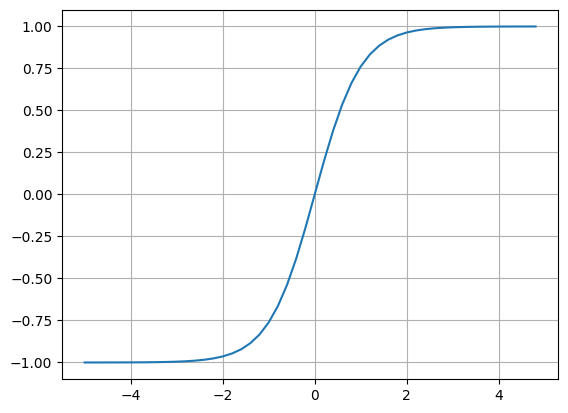

In [22]:
# example of backpropagation through the neuron 
# 1. the activation function like tanh is just going to squash the net
# product to be between -1 and 1
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

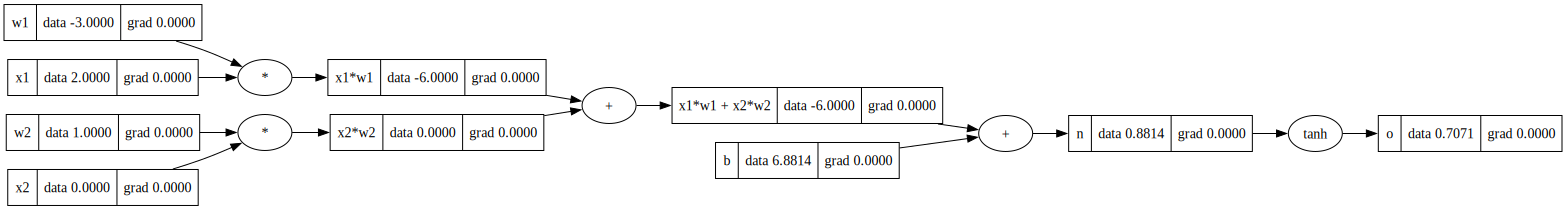

In [98]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'
draw_dot(o)


In [102]:
o.backward()

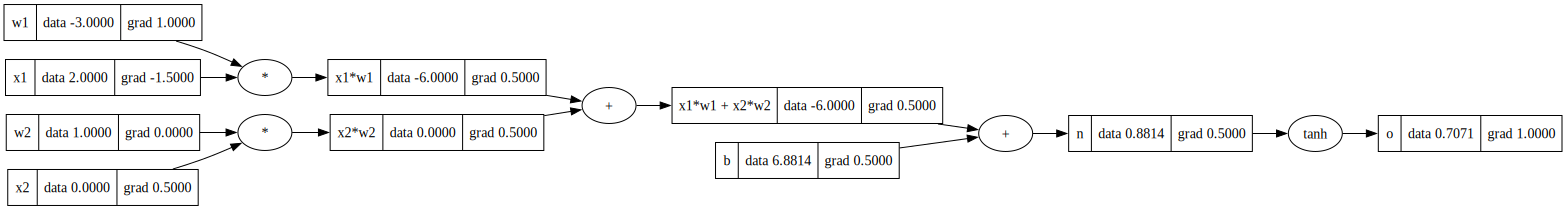

In [100]:
draw_dot(o)

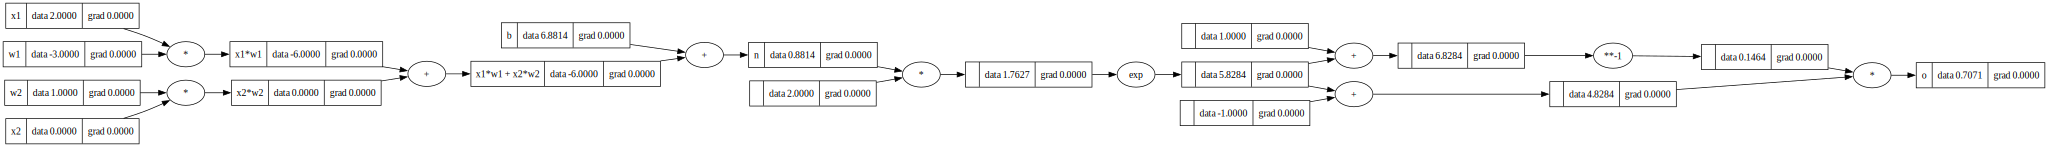

In [101]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
draw_dot(o)


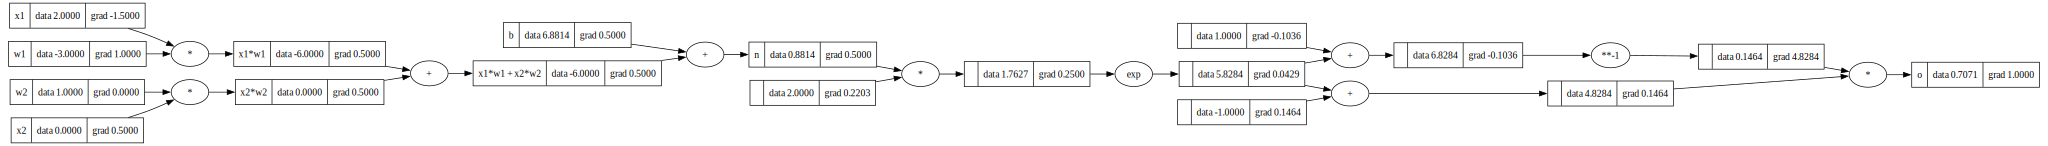

In [103]:
draw_dot(o)


In [108]:
# re-create the work with torch

x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())



0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0
x2 0.5000001283844369


In [109]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [110]:
o.item()

0.7071066904050358

In [111]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [114]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5050866494933722)

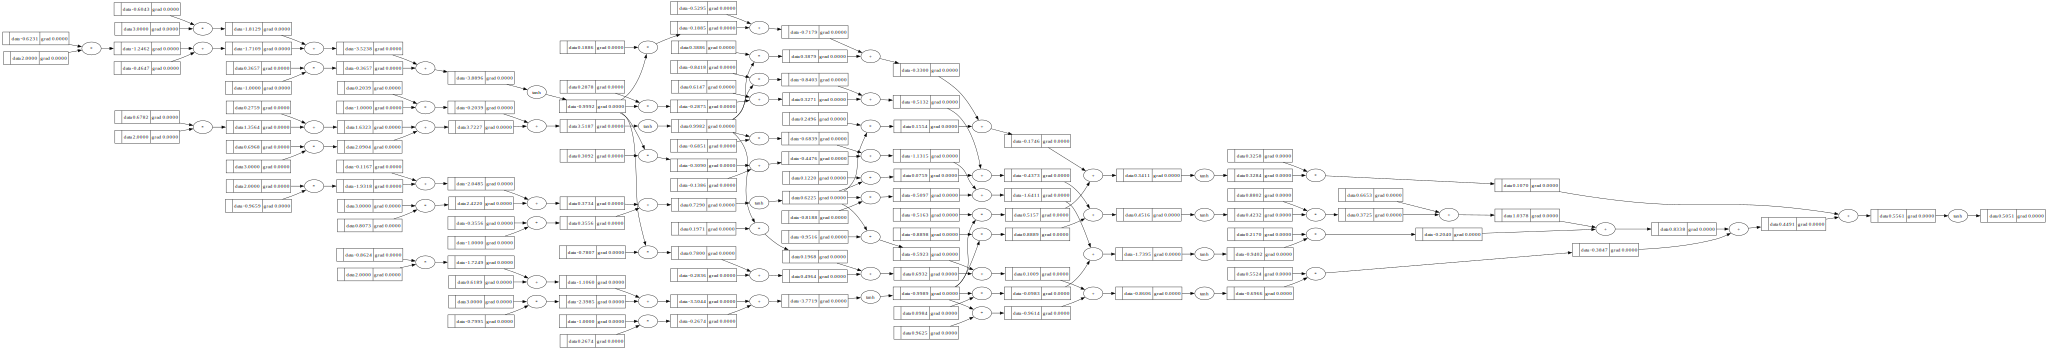

In [116]:
draw_dot(n(x))

In [117]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [120]:
ypred= [n(x) for x in xs]
ypred

[Value(data=0.5050866494933722),
 Value(data=0.771978621269059),
 Value(data=0.4892782409707715),
 Value(data=0.5929461787867957)]

In [127]:
#loss function
for k in range(30):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.0007175353887119932
1 0.0007154069131431915
2 0.0007132908229160121
3 0.0007111870109665317
4 0.000709095371456728
5 0.0007070157997569537
6 0.0007049481924288227
7 0.0007028924472083515
8 0.0007008484629893204
9 0.0006988161398070617
10 0.0006967953788223696
11 0.000694786082305747
12 0.0006927881536219285
13 0.0006908014972146783
14 0.0006888260185917134
15 0.0006868616243100825
16 0.000684908221961593
17 0.0006829657201585932
18 0.0006810340285199678
19 0.0006791130576573255
20 0.0006772027191614487
21 0.000675302925588957
22 0.0006734135904491961
23 0.0006715346281913127
24 0.000669665954191537
25 0.0006678074847407363
26 0.0006659591370320819
27 0.0006641208291489678
28 0.0006622924800531006
29 0.0006604740095727939


In [128]:
ypred

[Value(data=0.9920212000867553),
 Value(data=-0.9898556509448593),
 Value(data=-0.9831466353107728),
 Value(data=0.9855131424243704)]